In [17]:
import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
import itertools 

In [73]:
npath = '/Users/Clara Escanuela/OneDrive/Escritorio/MPhys_project/root_files/'
cpath = '/Users/Clara Escanuela/Downloads/'

path = cpath


def optim_bins(mult_arry):
    width_arry = np.array([])
    
    for arry in mult_arry: 
        #print(arry)
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    print(energy_res)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))


def hist_weights(rates, data):
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event) #fraction = expected events / num of events generated
        weights.append(weight)
        i += 1
    
    return weights

def root_input(path, filename):
    rTree = uproot.open(path + filename)
    
    rTree_event = rTree['event_tree']
    rTree_data = rTree['data_tree']
    #rTree_vuv = rTree['data_tree_vuv']
    
    #event_x_pos = np.array(rTree_event['event_x_pos'])
    event_E = np.array(rTree_event['event_E'])

    data_event = np.array(rTree_data['data_event'])
    #data_pmt = np.array(rTree_data['data_pmt'])
    data_time = np.array(rTree_data['data_time']) 

    data_index, count_scint = np.unique(data_event, return_counts=True)
    #split_pmt = np.split(data_pmt, np.cumsum(count_scint)) 
    split_time = np.split(data_time, np.cumsum(count_scint))

    return split_time, count_scint, event_E


def pairwise(iterable):
    "s -> (s0,s1), (s2,s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

fname_B8 = 'events_solar_delayed.root'
fname_B82 = 'events_solar_prompt.root'
fname_solar = 'events_b8.root'
fname_Ar36 = 'events_neutrons_36Ar_100000_foils.root'
fname_Ar40 = 'events_neutrons_40Ar_100000_foils.root'
fname_Rn = 'events_Rn222_100000_foils.root'
fname_AG = 'events_alphagamma_200000_foils.root'

B8_split_time, B8_scint, B8_event_E = root_input(path, fname_B8) 
B82_split_time, B82_scint, B82_event_E = root_input(path, fname_B82)
solar_split_time, solar_scint, solar_event_E = root_input(path, fname_solar) 

Ar36_split_time, Ar36_scint, Ar36_event_E = root_input(path, fname_Ar36)  
Ar40_split_time, Ar40_scint, Ar40_event_E = root_input(path, fname_Ar40)  
Rn_split_time, Rn_scint, Rn_event_E = root_input(path, fname_Rn)  
AG_split_time, AG_scint, AG_event_E = root_input(path, fname_AG)  

#########################

def comb(split_time, event_E):
    split_time_temp = []
    for x, y in pairwise(split_time):
        split_time_temp.append(np.append(x,y))
    
    event_E_temp = []
    for x, y in pairwise(event_E):
        event_E_temp.append(x+y)
    
    return split_time_temp, event_E_temp

B8_split_time, B8_event_E = comb(B8_split_time, B8_event_E)
AG_split_time, AG_event_E = comb(AG_split_time, AG_event_E)
outputtime = np.hstack((B8_split_time[0:4000], B82_split_time[0:6000]))

print(B8_event_E[0:10])
outputE = np.hstack((B8_event_E[0:4000], B82_event_E[0:6000]))

B8_split_time = outputtime
B8_event_E = outputE

[8.452194427931296, 10.372025903313627, 8.271617456364064, 12.591674714396076, 8.042225217157705, 10.767931515595134, 9.837133770835322, 10.87852884800631, 9.944258712391685, 14.00789293039905]


C:\Users\Clara Escanuela\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


24.232627592479247


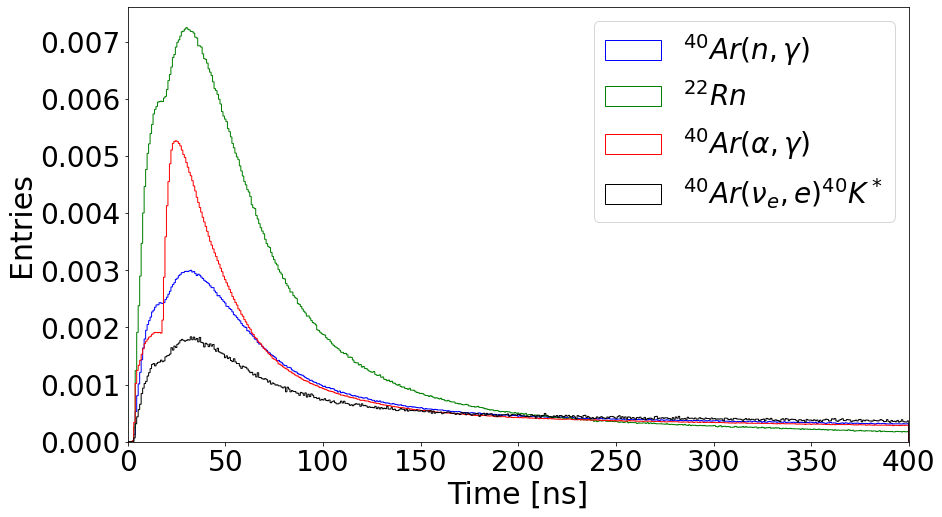

In [74]:
# Plot time distribution

data = [np.concatenate(B8_split_time)*1000, np.concatenate(AG_split_time)*1000, np.concatenate(Rn_split_time)*1000, np.concatenate(Ar40_split_time)*1000]
rates = [1, 1, 1, 1] # normalise

num_bins = optim_bins(data)

labels = [r'$^{40}Ar(\nu_e, e)^{40}{K}^*$', r'${}^{40} Ar(\alpha, \gamma)$', r'${}^{22} Rn$', r'${}^{40} Ar(n, \gamma)$']
colors = ['black', 'red', 'green', 'blue']

plt.figure(figsize=(14,8))

n, bins, patches = plt.hist(data, stacked = False, color=colors, bins=num_bins, range=[0, 400], label=labels, histtype='step', weights=hist_weights(rates, data))

n0 = np.max(n[0])/np.max(n[2])
n1 = np.max(n[1])/np.max(n[2])
n3 = np.max(n[3])/np.max(n[2])

plt.xlabel('Time [ns]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Entries',fontsize=30)
plt.yticks(fontsize=28)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
plt.xlim(-0.1, 400)

plt.legend(fontsize=28)

plt.show()

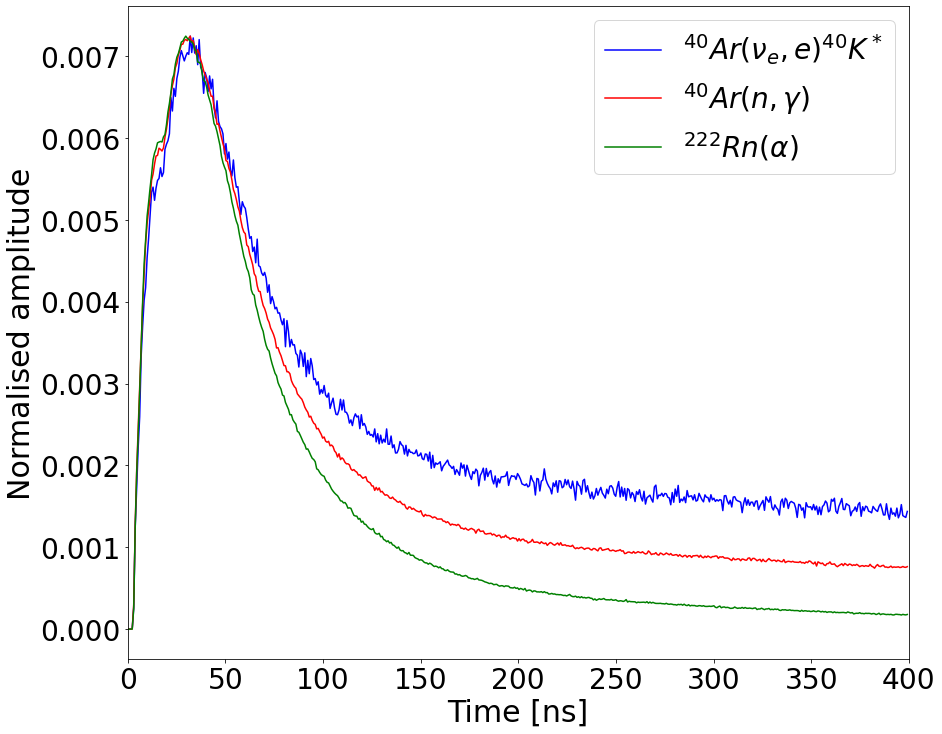

In [75]:
plt.figure(figsize=(14,12))

plt.plot(bins[0:num_bins], n[0][0:num_bins]/n0, label=r'$^{40}Ar(\nu_e, e)^{40}{K}^*$', color='blue')
plt.plot(bins[0:num_bins], n[3][0:num_bins]/n3, label=r'${}^{40} Ar(n, \gamma)$', color='red')
plt.plot(bins[0:num_bins], n[2][0:num_bins], label=r'${}^{222} Rn (\alpha)$', color='green')

plt.xlabel('Time [ns]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Normalised amplitude',fontsize=30)
plt.yticks(fontsize=28)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
#plt.axvline(x=200, color='black', linestyle='dashed', linewidth=0.7)
plt.xlim(-0.1, 400)

plt.legend(fontsize=28)

plt.show()

0.018946226530942512


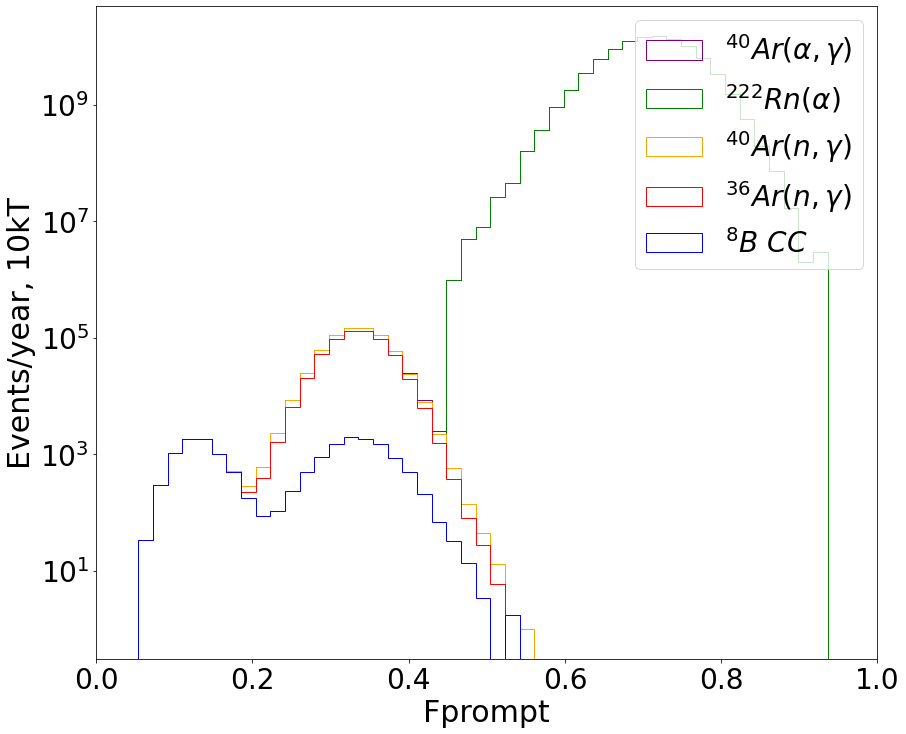

In [76]:
#Fprompt

def Fprompt(split_time, time):

    fprompt = np.array([])

    for event in split_time:
        if event.size > 0:
            fprompt = np.append(fprompt, len(event[event <= time*0.001])/len(event))
            
    return fprompt

#####################

max_time = 200

Fprompt_B8 = Fprompt(B8_split_time, max_time)

Fprompt_Ar36 = Fprompt(Ar36_split_time, max_time)
Fprompt_Ar40 = Fprompt(Ar40_split_time, max_time)
Fprompt_Rn = Fprompt(Rn_split_time, max_time)
Fprompt_AG = Fprompt(AG_split_time, max_time)


rates = [26700*0.64, 10**8*0.006, 10**8*0.994*(1/10**3), 10**(11), 3000] # normalise

data = [Fprompt_B8, Fprompt_Ar36, Fprompt_Ar40, Fprompt_Rn, Fprompt_AG]

labels = [r'${}^8 B\ CC$', r'${}^{36} Ar(n, \gamma)$', r'${}^{40} Ar(n, \gamma)$', r'${}^{222} Rn(\alpha)$', r'${}^{40} Ar(\alpha, \gamma)$']
colors = ['blue', 'red', 'orange', 'green', 'purple']

plt.figure(figsize=(14,12))

num_bins = optim_bins(data)

n_, bins_, patches_ = plt.hist(data, stacked = True, color=colors, bins=num_bins, label=labels, histtype='step', weights=hist_weights(rates, data))

plt.xlabel('Fprompt',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Events/year, 10kT',fontsize=30)
plt.yticks(fontsize=28)
plt.xlim([0, 1])
plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

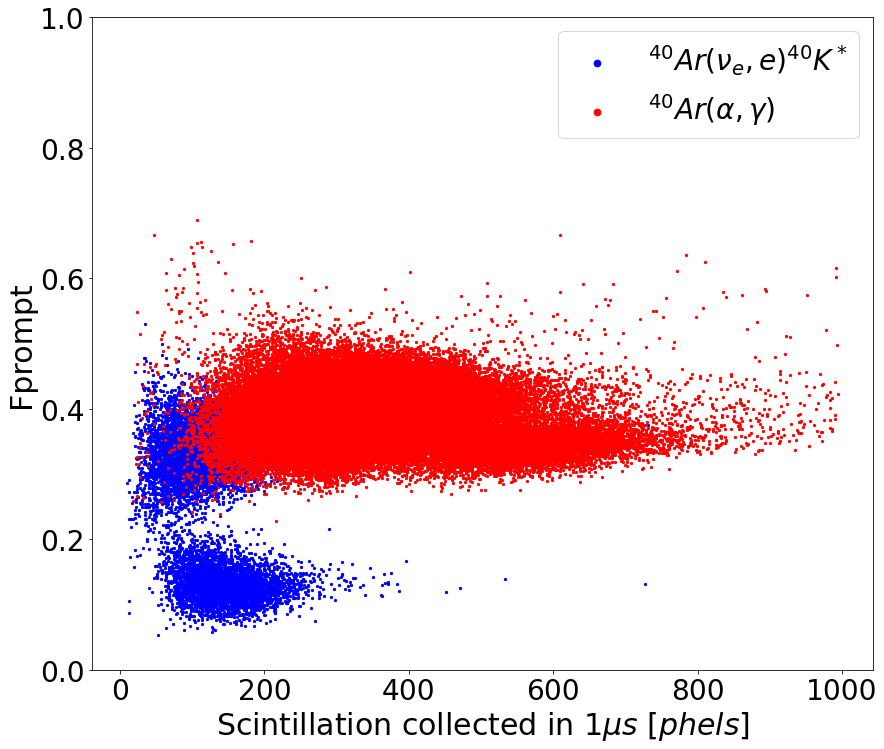

In [77]:
#########################

def scint_timewindow(split_time, set_time):
    #time is in microseconds
    i = 0
    scint_output = np.array([])

    for time in split_time:
        mask = (time <= set_time)
    
        if time.size > 0:
            scint_output = np.append(scint_output, len(time[mask])) # number of photons detected in time window
        i += 1
    
    return scint_output


t_window = 1

signl_wind = scint_timewindow(B8_split_time, t_window)
bkg_wind = scint_timewindow(AG_split_time, t_window)

#########################

plt.figure(figsize=(14,12))

sig_label = r'$^{40}Ar(\nu_e, e)^{40}{K}^*$'
bkg_label = r'${}^{40} Ar(\alpha, \gamma)$'

num_mask = 2000
scint_mask = 1000
plt.scatter(signl_wind[signl_wind < scint_mask], Fprompt_B8[signl_wind < scint_mask], s = 20, label=sig_label, marker='.', color='blue')

plt.scatter(bkg_wind[bkg_wind < scint_mask], Fprompt_AG[bkg_wind < scint_mask], s = 20, label=bkg_label, marker='.', color='red')
#plt.axhline(y=0.2, color='black', linestyle='dashed', linewidth=0.7)

plt.ylabel('Fprompt', fontsize=30)
plt.xlabel(r'Scintillation collected in $1 \mu s$ [$phels$]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(markerscale=3, fontsize=28)
plt.ylim(0,1)

plt.show()


In [78]:
bin_width = bins_[1] - bins_[0]

totaln = n_[1] + n_[2] + n_[3] + n_[4]

total_sign = bin_width * sum(n_[0])
total_back = bin_width * sum(totaln)

sign = bin_width * sum(n_[0][np.where(bins_<=0.2)])
back = bin_width * sum(totaln[np.where(bins_<=0.2)])

print(sign/total_sign)
print(back)

0.39499999999996865
515.4676451407083


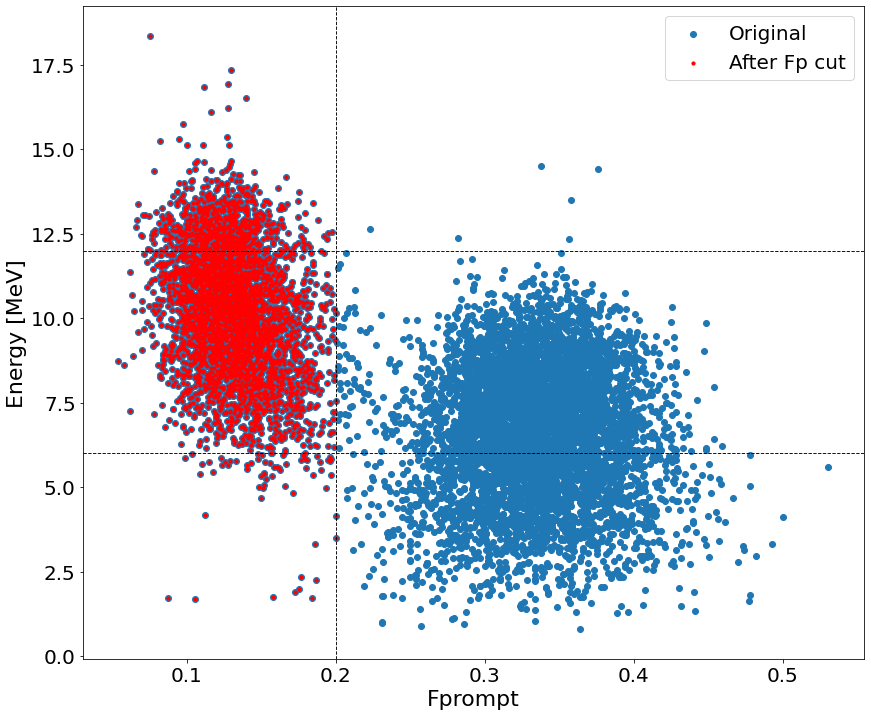

In [79]:
plt.figure(figsize=(14,12))

plt.scatter(Fprompt_B8, B8_event_E, label='Original')
plt.scatter(Fprompt_B8[Fprompt_B8<=0.2], B8_event_E[Fprompt_B8<=0.2], color='red', s=10, label='After Fp cut')

plt.xlabel('Fprompt',fontsize=22)
plt.xticks(fontsize=20)
plt.ylabel('Energy [MeV]',fontsize=22)
plt.yticks(fontsize=20)
plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
plt.axhline(y=12, linestyle = "dashed", color="black", linewidth = 0.9)
plt.axhline(y=6, linestyle = "dashed", color="black", linewidth = 0.9)
#plt.xlim(0, 10)

plt.legend(fontsize=20)

plt.show()

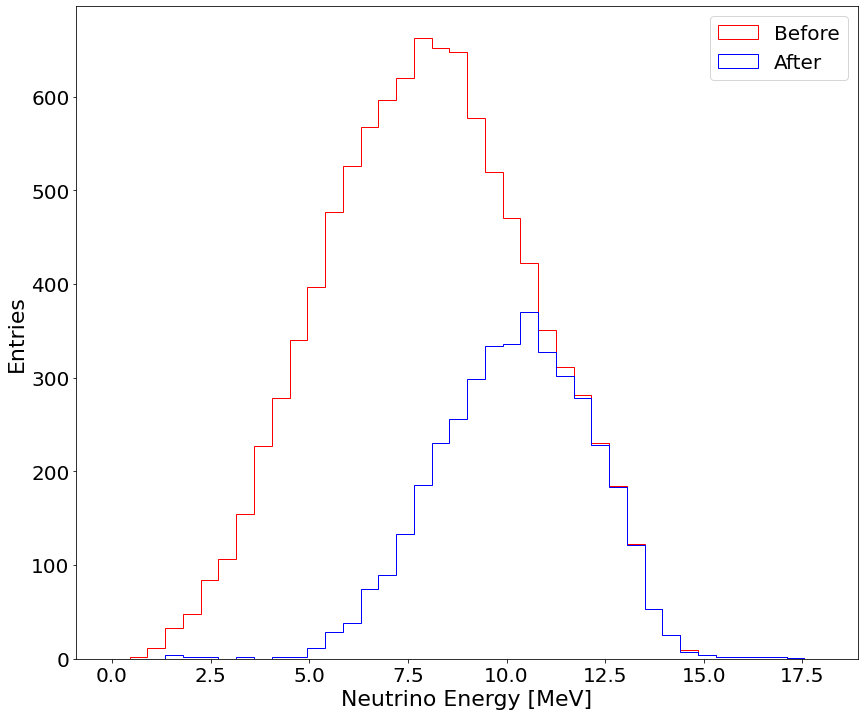

In [89]:
plt.figure(figsize=(14,12))

#data = [B8_event_E, B8_event_E[Fprompt_B8<=0.2]]

num_bins = 40 #optim_bins([B8_event_E])

#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-((x)-x0)**2/(2*sigma**2))


#n, bins, patches = plt.hist(data, stacked = False, bins=num_bins, label=['Before', 'After'], range=(0,18), histtype='step', color=['red', 'blue'])

n_before, bins_before, patches_before = plt.hist(B8_event_E ,stacked = False, bins=num_bins, label='Before', range=(0,18), histtype='step', color='red')
n_after, bins_after, patches_after = plt.hist(B8_event_E[Fprompt_B8<=0.2] ,stacked = False, bins=num_bins, range=(0, 18), label='After', histtype='step', color='blue')

plt.xlabel('Neutrino Energy [MeV]',fontsize=22)
plt.xticks(fontsize=20)
plt.ylabel('Entries',fontsize=22)
plt.yticks(fontsize=20)
#plt.axvline(x=0.2, linestyle = "dashed", color="black", linewidth = 0.9)
#plt.xlim(0, 10)

plt.legend(fontsize=20)

plt.show()

C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_15944/3713603025.py:8: RuntimeWarning: invalid value encountered in double_scalars
  efficiency = n_after[i]/n_before[i]


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

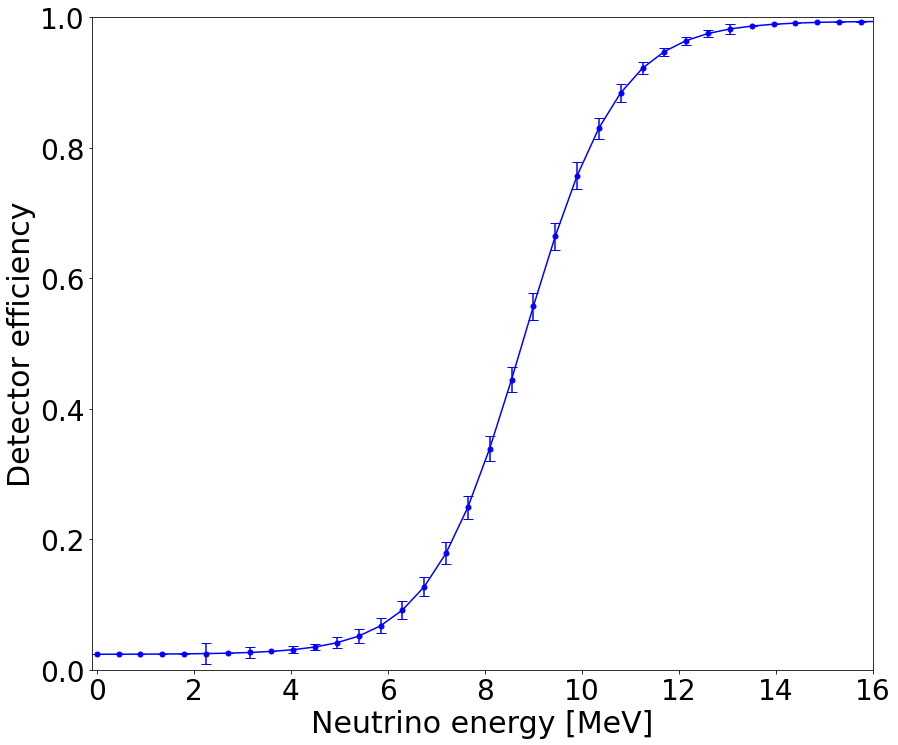

In [94]:
eff_ener = np.array([])
err_eff=np.array([])
energy = np.linspace(0, 18, num_bins)

bin_width = bins_before[0] - bins_before[1]

for i in range(0, num_bins):
    efficiency = n_after[i]/n_before[i]
    eff_ener = np.append(eff_ener, efficiency)
    
def std(na, nb):
    #Bayesian statistics
    return np.sqrt(((na+1)*(na+2))/((nb+2)*(nb+3))-(na+1)**2/(nb+2)**2)

def errors_bin(na, nb):
    #Binomial errors
    std = np.sqrt((1/nb**2)*((na)*(1-na/nb)))
    return std

for i in range(0, num_bins):
    err_eff = np.append(err_eff, (errors_bin(n_after[i], n_before[i])))


eff_ener[np.isnan(eff_ener)] = 0 
err_eff[np.isnan(err_eff)] = 0 

def sigmoid(x, a, b, c, d, e):
    return a/(d + np.exp(-b*x+c))+e

plt.figure(figsize=(14,12))

popt, pcov = curve_fit(sigmoid, bins_before[0:num_bins-1], eff_ener[0:num_bins-1])

plt.plot(bins_before[0:num_bins],sigmoid(bins_before[0:num_bins], *popt), color='blue')
plt.errorbar(bins_before[0:num_bins], sigmoid(bins_before[0:num_bins], *popt), yerr=err_eff, fmt='o', color='blue', markersize=5, capsize=5)

plt.xlim(-0.1, 16)
plt.ylim(0, 1)

plt.ylabel('Detector efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)
#plt.yscale('log')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
#plt.legend(fontsize=28)